# I.3 Divided Differences

We now get to our first computational problem: given a function, how can we approximate its derivative at a
point? We consider an intuitive approach to this problem using _Divided Differences_: 
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
for $h$ small. From the definition of a derivative we know that as $h → 0$ the approximation (the right-hand side)
converges to $f'(x)$, hence a natural algorithm is use this formula for very small $h$. 
Unfortunately, the round-off errors of floating point arithmetic introduces typically limit its accuracy.

In this chapter we view $f$ as a _Black-box function_ which we can only evaluate _pointwise_: Consider a floating-point valued function $f^{\rm FP} : D \rightarrow F$ where 
$D \subset F \equiv F_{σ,Q,S}$.
For example, if we have `f(x::Float64) = sqrt(x)` then our function is defined only for positive `Float64` (otherwise it throws an error)
hence $D = [0,∞) ∩ F_{64}$. This is the situation if we have a function that relies on a compiled C library,
which hides the underlying operations (which are usually composition of floating point operations).
Since the set of floating point numbers $F$ is discrete, $f^{\rm FP}$ cannot be differentiable in an obvious way,
therefore we need to assume that $f^{\rm FP}$ approximates a differentiable function $f$ with controllable
error bounds in order to state anything precise.

In the next chapter (I.4) we wiil introduce a more accurate approach based on _dual numbers_, which requires a more general
notion of a function where a formula (i.e., code) is available. 


Note there are other techniques for differentiation that we don't discuss:

1. Symbolic differentiation: A tree is built representing a formula which is differentiated using
the product and chain rule.
2. Adjoints and back-propagation (reverse-mode automatic differentiation): This is similar to
symbolic differentiation but automated, where the adjoints of Jacobians of each operation are constructed
in a way that they can be composed (essentially the chain rule).
It's outside the scope of this module but is computationally preferred for computing gradients
of large dimensional functions which is critical in machine learning.
4. Interpolation and differentiation: We can also differentiate functions _globally_, that is, in an interval instead of
only a single point, which will be discussed in Part III of the module.

In [4]:
using ColorBitstring, Plots

## 1. Divided differences

The definition 
$$
f'(x) = \lim_{h \rightarrow 0} {f(x+h) - f(x) \over h}
$$
tells us that
$$
f'(x) \approx {f(x+h) - f(x) \over h}
$$
provided that $h$ is sufficiently small. 

It's important to note that approximation uses only the _black-box_
notion of a function but to obtain bounds we need more.

If we know a bound on $f''(x)$ then Taylor's theorem tells us a precise bound:

**Proposition 1**
The error in approximating the derivative using divided differences is
$$
\left|f'(x) - {f(x+h) - f(x) \over h}\right| ≤ {M \over 2} h
$$
where $M = \sup_{x ≤ t ≤ x+h} |f''(t)|$.

**Proof**
Follows immediately from Taylor's theorem:
$$
f(x+h) = f(x) + f'(x) h + {f''(t) \over 2} h^2
$$
for some $x ≤ t ≤ x+h$.

◼️




There are also alternative versions of divided differences. Leftside divided differences:
$$
f'(x) ≈ {f(x) - f(x-h) \over h}
$$
and central differences:
$$
f'(x) ≈ {f(x + h) - f(x - h) \over 2h}
$$
Composing these approximations is useful for higher-order derivatives as we 
discuss in the problem sheet.

Note this is assuming _real arithmetic_, the answer is drastically
different with _floating point arithmetic_.

## 2. Does divided differences work with floating point arithmetic?



Let's try differentiating two simple polynomials $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$
by applying the divided difference approximation to their floating point implementations
$f^{\rm FP}$ and $g^{\rm FP}$:

$f^{FP} = 1 ⊕ x ⊕ (x ⊗ x)$

In [2]:
f = x -> 1 + x + x^2     # we treat f and g as black-boxs
g = x -> 1 + x/3 + x^2
h = 0.000001
(f(h)-f(0))/h, (g(h)-g(0))/h

(1.000001000006634, 0.33333433346882657)

Both seem to roughly approximate the true derivatives ($1$ and $1/3$).
We can do a plot to see how fast the error goes down as we let $h$ become small.

In the case of $f$ it is a success: we approximate the true derivative _exactly_ provided we take $h = 2^{-n}$
for $26 < n ≤ 52$.
But for $g$ it is a huge failure: the approximation starts to converge, but then diverges exponentially fast, before levelling off!

It is clear that $f$ is extremely special. Most functions will behave like $g$, and had we not taken
$h$ to be a power of two we also see divergence for differentiating $f$:

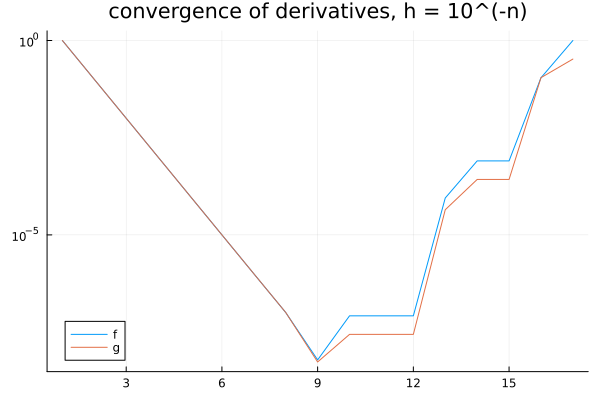

In [5]:
h = 10.0 .^ (0:-1:-16)  # [1,1/10,1/100,…]
plot(abs.((f.(h) .- f(0)) ./ h .- 1); yscale=:log10, title="convergence of derivatives, h = 10^(-n)", label="f", legend=:bottomleft)
plot!(abs.((g.(h) .- g(0)) ./ h .- 1/3); yscale=:log10, label = "g")

For these two simple
examples, we can understand why we see very different behaviour.


**Example 1 (convergence(?) of divided differences)** Consider differentiating $f(x) = 1 + x + x^2$ at 0 with $h = 2^{-n}$.
We consider 4 different cases with different behaviour, where $S$ is the number of significand bits: 

1. $0 ≤ n ≤ S/2$
2. $S/2 < n ≤ S$
3. $S ≤ n < S + σ$
4. $S + σ ≤ n$

Note that $f^{\rm FP}(0) = f(0) = 1$. Thus we wish to understand the error in approximating $f'(0) = 1$ by
$$
(f^{\rm FP}(h) ⊖ 1) ⊘ h\qquad\hbox{where}\qquad f^{\rm FP}(x) = 1 ⊕ x ⊕ x ⊗ x.
$$

_Case 1_ ($0 ≤ n ≤ S/2$): note that $f^{\rm FP}(h) = f(h) = 1 + 2^{-n} + 2^{-2n}$
as each computation is precisely a floating point number (hence no rounding). We can see this in half-precision,
with $n = 3$ we have a 1 in the 3rd and 6th decimal place:

In [ ]:
S = 10 # 10 significant bits
n = 3  # 3 ≤ S/2 = 5
h = Float16(2)^(-n)
printbits(f(h))

0011110010010000

Subtracting 1 and dividing by $h$ will also be exact, hence we get
$$
(f^{\rm FP}(h) ⊖ 1) ⊘ h = 1 + 2^{-n}
$$
which shows exponential convergence.

_Case 2_ ($S/2 < n ≤ S$): Now we have (using round-to-nearest)
$$
f^{\rm FP}(h) = (1 + 2^{-n}) ⊕ 2^{-2n} = 1 + 2^{-n}
$$
Then
$$
(f^{\rm FP}(h) ⊖ 1) ⊘ h = 1 = f'(0)
$$
We have actually performed better than true real arithmetic and converged without a limit!

_Case 3_ ($S < n <  σ + S$): If we take $n$ too large, then $1 ⊕ h = 1$ and we have $f^{\rm FP}(h) = 1$, that is and 
$$
(f^{\rm FP}(h) ⊖ 1) ⊘ h = 0 \neq f'(0)
$$

_Case 4_ ($σ + S ≤ n$): In this case $h = 2^{-n}$ is rounded to zero
and hence we get $NaN$.

**Example 2 (divergence of divided differences)** Consider differentiating $g(x) = 1 + x/3 + x^2$ at 0 with $h = 2^{-n}$
and assume $n$ is even for simplicity and consider half-precision with $S = 10$.
Note that $g^{\rm FP}(0) = g(0) = 1$.
Recall
$$
h ⊘ 3 = 2^{-n-2} * (1.0101010101)_2
$$
Note we lose two bits each time in the computation of $1 ⊕ (h ⊘ 3)$:

In [ ]:
n = 0; h = Float16(2)^(-n); printlnbits(1 + h/3)
n = 2; h = Float16(2)^(-n); printlnbits(1 + h/3)
n = 4; h = Float16(2)^(-n); printlnbits(1 + h/3)
n = 8; h = Float16(2)^(-n); printlnbits(1 + h/3)

0011110101010101
0011110001010101
0011110000010101
0011110000000001


It follows if $S/2 < n < S$ that
$$
1 ⊕ (h ⊘ 3) = 1 + h/3 - 2^{-10}/3
$$
Therefore
$$
(g^{\rm FP}(h) ⊖ 1) ⊘ h = 1/3 - 2^{n-10}/3
$$
Thus the error grows exponentially with $n$. 


If $S ≤ n <  σ + S$ then $1 ⊕ (h ⊘ 3) = 1$ and we have
$$
(g^{\rm FP}(h) ⊖ 1) ⊘ h = 0
$$


## 3. Bounding the error


We can bound the error using the bounds on floating point arithmetic. 

**Theorem 1 (divided difference error bound)** Let $f$ be twice-differentiable in a neighbourhood of $x$ and assume that 
$$
f^{\rm FP}(x) = f(x) + δ_x^f
$$
has uniform absolute accuracy in that neighbourhood, that is:
$$
|δ_x^f| ≤ c ϵ_{\rm m}
$$
for a fixed constant $c ≥ 0$. Assume for simplicity $h = 2^{-n}$ where $n ≤ S$ and $|x| ≤ 1$. 
Assuming that all calculations result in normal floating point numbers,
the divided difference approximation satisfies
$$
(f^{\rm FP}(x + h) ⊖ f^{\rm FP}(x)) ⊘ h = f'(x) + δ_{x,h}^{\rm FD}
$$
where 
$$
|δ_{x,h}^{\rm FD}| ≤ {|f'(x)| \over 2} ϵ_{\rm m} + M h +  {4c ϵ_{\rm m} \over h}
$$
for $M = \sup_{x ≤ t ≤ x+h} |f''(t)|$.

**Proof**

We have (noting by our assumptions $x ⊕ h = x + h$ and that dividing by $h$ will only change the exponent so
is exact)
$$
\begin{align*}
(f^{\rm FP}(x + h) ⊖ f^{\rm FP}(x)) ⊘ h &= {f(x + h) +  δ^f_{x+h} - f(x) - δ^f_x \over h} (1 + δ_1) \\
&= {f(x+h) - f(x) \over h} (1 + δ_1) + {δ^f_{x+h}- δ^f_x \over h} (1 + δ_1)
\end{align*}
$$
where $|δ_1| ≤ {ϵ_{\rm m} / 2}$. Applying Taylor's theorem we get 
$$
(f^{\rm FP}(x + h) ⊖ f^{\rm FP}(x)) ⊘ h = f'(x) + \underbrace{f'(x) δ_1 + {f''(t) \over 2} h (1 + \delta_1) + {δ^f_{x+h}- δ^f_x \over h} (1 + δ_1)}_{δ_{x,h}^{\rm FD}}
$$
The bound then follows, using the very pessimistic bound $|1 + δ_1| ≤ 2$.

∎

The three-terms of this bound tell us a story: the first term is a fixed (small) error, the second term tends to zero
as $h \rightarrow 0$, while the last term grows like $ϵ_{\rm m}/h$ as $h \rightarrow 0$.  Thus we observe convergence
while the second term dominates, until the last term takes over.
Of course, a bad upper bound is not the same as a proof that something grows, but it is a good indication of 
what happens _in general_ and suffices to motivate the following heuristic to balance the two sources of errors:


**Heuristic (divided difference with floating-point step)** Choose $h$ proportional to $\sqrt{ϵ_{\rm m}}$
in divided differences.

In the case of double precision $\sqrt{ϵ_{\rm m}} ≈ 1.5\times 10^{-8}$, which is close to when the observed error begins to increase
in our examples.



**Remark** While divided differences is of debatable utility for computing derivatives, it is extremely effective
in building methods for solving differential equations, as we shall see later. It is also very useful as a "sanity check"
if one wants something to compare with for other numerical methods for differentiation.